In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score, cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from pprint import pprint
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
red_wine=pd.read_csv("winequality-red.csv",sep=";")
white_wine=pd.read_csv("winequality-white.csv",sep=";")
#Column renaming according to usual conventions
red_wine.columns=red_wine.columns.str.replace(" ","_")
white_wine.columns=white_wine.columns.str.replace(" ","_")
#Categorization of quality into three groups
red_wine["quality_label"] = red_wine["quality"].apply(lambda value: 0 if value<=5 else 1 if value< 7 else 2)
white_wine["quality_label"]=white_wine["quality"].apply(lambda value: 0 if value<=5 else 1 if value< 7 else 2)
red_wine["quality_label"]=pd.Categorical(red_wine["quality_label"],categories=[0,1,2])
white_wine["quality_label"]=pd.Categorical(white_wine["quality_label"],categories=[0,1,2])
#Combining the two wine databases
wines=pd.concat([red_wine,white_wine])
wines=wines.sample(frac=1,random_state=42).reset_index(drop=True)

In [278]:
x=red_wine.drop(["quality","quality_label"],axis=1)
y=red_wine["quality_label"]
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=42)
xtrain_norm=xtrain
xtest_norm=xtest

In [ ]:
#Data is normalised since distribution for all except pH is skewed
#Normalisation only has a noticeable impact in non RF methods, and it's better with StandardScaler
#However it results in lost of variance, concentrating most wines in one quality
#If not normalised, the accuracy is less than 50%. With normalisation it it around 57%.
norm=StandardScaler()
norm_fit=norm.fit(xtrain)
xtrain_norm=norm_fit.transform(xtrain)
xtest_norm=norm_fit.transform(xtest)

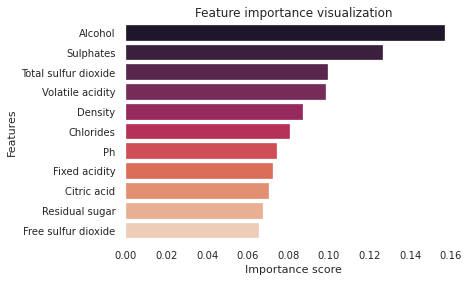

In [282]:
#Feature visualization for RF
temp=RandomForestClassifier(n_estimators=100)
temp.fit(xtrain,ytrain)
feature_imp=pd.Series(temp.feature_importances_,index=x.columns[:11]).sort_values(ascending=False)
feature_imp.index=feature_imp.index.str.replace("_"," ")
feature_imp.index=feature_imp.index.str.capitalize()
sns.barplot(x=feature_imp,y=feature_imp.index,palette="rocket")
plt.xlabel("Importance score")
plt.ylabel("Features")
plt.title("Feature importance visualization")
plt.show()

In [ ]:
#RandomizedSearch parameter tuning
n_estimators=[200,400,600,800,1000]
max_features=["auto","sqrt","log2"]
max_depth=[int(x) for x in np.linspace(10,100,num=10)]
max_depth.append(None)
min_samples_split=[1,2.3,5]
min_samples_leaf=[1,2,4]
bootstrap=[True,False]
grid={"n_estimators":n_estimators,"max_features":max_features,"max_depth":max_depth,
"min_samples_split":min_samples_split,"min_samples_leaf":min_samples_leaf,"bootstrap":bootstrap}
rf=RandomForestRegressor()
random_grid=RandomizedSearchCV(estimator=rf,param_distributions=grid,n_iter=100,cv=3,verbose=2,random_state=42,n_jobs=-1)
random_grid.fit(xtrain,ytrain)
print(random_grid.best_params_)

In [ ]:
#GridSearch parameter tuning
n_estimators=[200,400,600]
max_features=["auto","sqrt","log2"]
max_depth=[None]
min_samples_split=[1,2]
min_samples_leaf=[1,2,3]
bootstrap=[False]
best_grid={"bootstrap":bootstrap,"max_depth":max_depth,"max_features":max_features,"min_samples_leaf":min_samples_leaf,
"min_samples_split":min_samples_split,"n_estimators":n_estimators}
rf=RandomForestRegressor()
grid_search=GridSearchCV(estimator=rf,param_grid=best_grid,cv=3,n_jobs=-1,verbose=2)
grid_search.fit(xtrain_norm,ytrain)
print(grid_search.best_params_)

In [ ]:
#The data should not be normalized nor standarized, as it consolidates all wines at the centre of distribution, where the majority are,
#losing variance in the process 
#White wines have the best score, 70%-71% with tuning, n_estimators=400
#Combined and red wines are around 65%
#For quality labels(n_estimators=400), it's 74% for white wines
#Combined dataset (max_features="log2") has 71% accuracy, red wines ~70%
rf=RandomForestClassifier(n_estimators=400,oob_score=True,n_jobs=-1)
rf.fit(xtrain_norm,ytrain)
pred_rf=rf.predict(xtest_norm)
a_rf=accuracy_score(ytest,pred_rf)
print(a_rf)
print(classification_report(ytest,pred_rf))
plot_confusion_matrix(rf,xtest,ytest)
plt.show()

In [ ]:
#Accuracy is ~55%
lr=LogisticRegression()
lr.fit(xtrain_norm,ytrain)
pred_lr=lr.predict(xtest_norm)
a_lr=accuracy_score(ytest,pred_lr)
print(a_lr)
print(classification_report(ytest,pred_lr))
plot_confusion_matrix(lr,xtest,ytest)
plt.show()

In [ ]:
#Accuracy is ~57%
svc=SVC(C=1000)
svc.fit(xtrain_norm,ytrain)
pred_svc=svc.predict(xtest_norm)
a_svc=accuracy_score(ytest,pred_svc)
print(a_svc)
print(classification_report(ytest,pred_svc))
plot_confusion_matrix(svc,xtest,ytest)
plt.show()

In [ ]:
#Accuracy is ~58%
knn=KNeighborsClassifier(n_neighbors=10,leaf_size=20)
knn.fit(xtrain_norm,ytrain)
pred_knn=knn.predict(xtest_norm)
a_knn=accuracy_score(ytest,pred_knn)
print(a_knn)
print(classification_report(ytest,pred_knn))
plot_confusion_matrix(knn,xtest,ytest)
plt.show()

Text(0.5, 1.0, 'Comperative accuracy of different models')

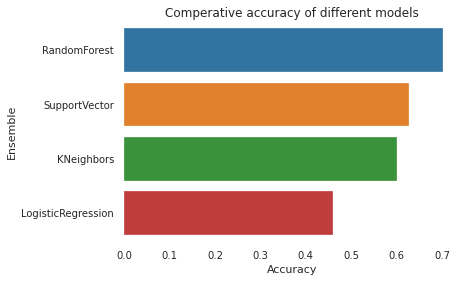

In [273]:
%matplotlib inline
mods=pd.DataFrame({"Ensemble":["RandomForest","LogisticRegression","SupportVector","KNeighbors"],"Accuracy":[a_rf,a_lr,a_svc,a_knn]})
mods.sort_values(by="Accuracy",ascending=False,inplace=True)
sns.barplot(x="Accuracy",y="Ensemble",data=mods)
plt.title("Comperative accuracy of different models")